In [2]:
%load_ext lab_black

from pathlib import Path
from collections import defaultdict
from typing import Iterable
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import groupby
from statistics import mean
from operator import attrgetter

RELEASE_OPT_LEVEL = 3

DATA_DIR = Path("./data")
DEVICE_DATA_PATHS = {str(p.stem): p for p in (DATA_DIR / "raw").iterdir() if p.is_dir()}

In [5]:
TestResult = namedtuple("RunResult", "device opt_level sort n duration")


def parse_single_run_results(lines: Iterable[str]):
    for l in lines:
        if l.startswith("Using"):
            sort = l.split("Using ")[1].strip()
        else:
            n, duration = [int(s) for s in l.split(", ")]
            yield sort, n, duration


def parse_device_results(device_path: Path):
    for p in device_path.iterdir():
        optimisation_level = int(p.stem.split("-")[1])
        with p.open() as f:
            for r in parse_single_run_results(f):
                yield (optimisation_level, *r)


def parse_all_results():
    return [
        TestResult(device, *r)
        for device, p in DEVICE_DATA_PATHS.items()
        for r in parse_device_results(p)
    ]


results = parse_all_results()

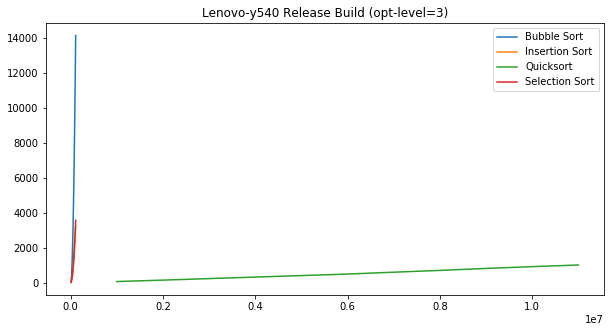

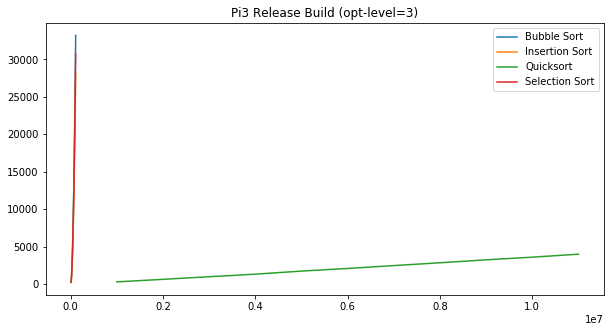

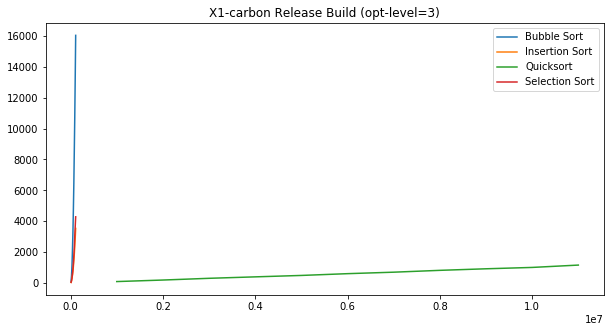

In [9]:
def sort_and_groupby(iterable, key=None):
    yield from groupby(sorted(iterable, key=key), key=key)


for device, g in sort_and_groupby(
    [r for r in results if r.opt_level == RELEASE_OPT_LEVEL], key=attrgetter("device")
):
    fig = plt.figure(figsize=(10, 5))
    plt.title(f"{device.capitalize()} Release Build (opt-level=3)")
    for sort, _results in sort_and_groupby(list(g), key=attrgetter("sort")):
        _results = list(_results)
        plt.plot([r.n for r in _results], [r.duration for r in _results], label=sort)
    plt.legend()
    plt.show()
    fig.savefig(DATA_DIR / "processed/devices" / device, dpi=fig.dpi)

In [7]:
def ddict():
    return defaultdict(ddict)


res = ddict()
AvgResult = namedtuple("AvgResult", ["opt_level", "sort", "n", "avg"])
avgs = []
avgs = ddict()
for (opt_level, sort, n), g in sort_and_groupby(
    results, key=attrgetter("opt_level", "sort", "n")
):
    avgs[sort][opt_level][n] = mean([r.duration for r in g])

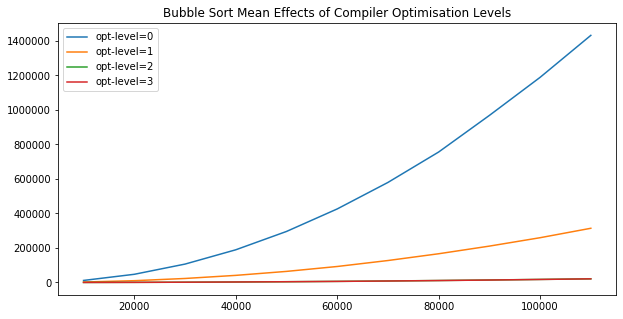

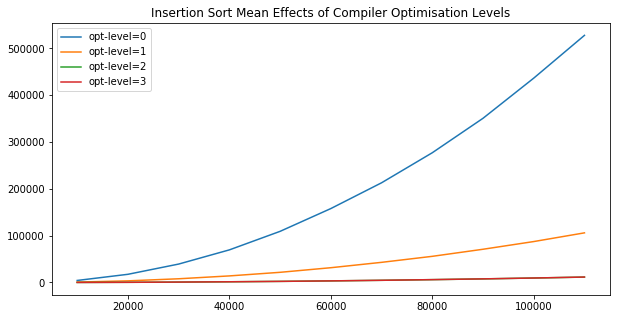

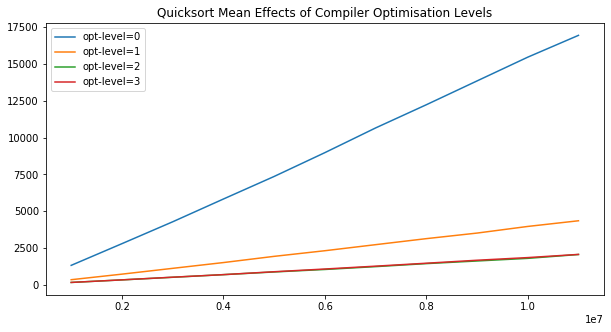

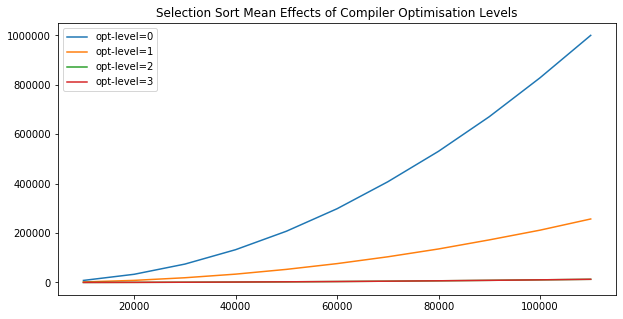

In [11]:
for sort, opt_levels in avgs.items():
    fig = plt.figure(figsize=(10, 5))
    plt.title(f"{sort} Mean Effects of Compiler Optimisation Levels")
    for opt_level, sort_results in opt_levels.items():
        plt.plot(
            list(sort_results.keys()),
            list(sort_results.values()),
            label=f"opt-level={opt_level}",
        )
    plt.legend()
    plt.show()
    fig.savefig(DATA_DIR / "processed/opt_levels" / sort, dpi=fig.dpi)